# Implementing Grover's algorithm with MPQP

In [ ]:
import math
import numpy as np
import random
from mpqp.gates import *
from mpqp import QCircuit

size_circ_grover = lambda nb_qubits: nb_qubits if nb_qubits <=3 else 2*nb_qubits -2

def ccc_not(controls: list[int], target: int) -> QCircuit:
    connections = controls + [target]
    nb_qubits = len(connections)

    if nb_qubits==1:
        instr = [X(0)]
    if nb_qubits==2:
        instr = [CNOT(1, 0)]
    elif nb_qubits==3:
        instr = [TOF([1,2], 0)]
    else:
        ancilas_start = max(connections) + 1
        ancilas = range(ancilas_start, ancilas_start + len(controls)-1)
        cascade = (
            [TOF([1,2],ancilas[0])] 
            + [TOF([i+3, ancilas[i]], ancilas[i+1]) for i in range(len(controls)-2)]
        )
        instr =  cascade + [CNOT(ancilas[-1], target)] + cascade[::-1]
    return QCircuit(instr)

## Initialize the circuit

The circuit is composed of a first register encoding the database, and a second register of ancillas. We first need to initialize the first register with a fully parallelized state.

For that, we define a ``h_wall``, circuit composed of Hadamard gates on every qubit.

In [2]:
from mpqp import QCircuit
from mpqp.gates import *

def h_wall(nb_qubits: int):
    return QCircuit([H(i) for i in range(nb_qubits)], nb_qubits=size_circ_grover(nb_qubits))

In [3]:
print(h_wall(3))

     ┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     └───┘


## Define the Oracle

The role of the Oracle is to mark with a minus sign the basis state representing the solution. It can be decomposed using a wall of ``X`` gates, applied according to the binary notation of the searched element, Hadamard gate on the first qubit, and a multi-controlled NOT on the first qubit, controlled by all the others.

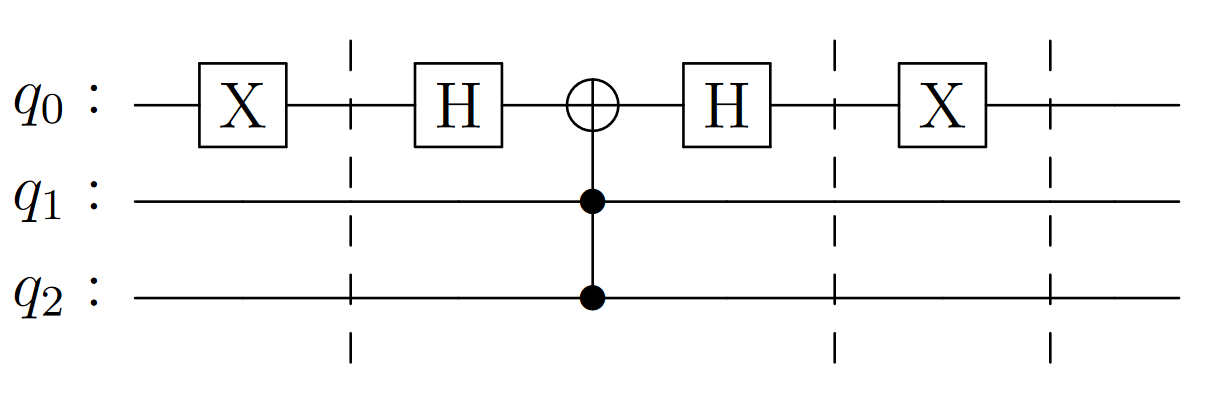
<center>Oracle for '011'</center>

In [4]:
def oracle(marked: str) -> QCircuit:
    nb_qubits = len(marked)
    x_wall = QCircuit([X(i) for i in range(len(marked)) if marked[i] == '0'], nb_qubits=nb_qubits)
    
    circ = QCircuit(size_circ_grover(nb_qubits))
    circ.append(x_wall)
    circ.add(H(0))
    circ.append(ccc_not(list(range(1,nb_qubits)) ,0))
    circ.add(H(0))
    circ.append(x_wall)
    
    return circ

c:\Users\Henri\anaconda3\lib\site-packages\mpqp\core\circuit.py:552: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


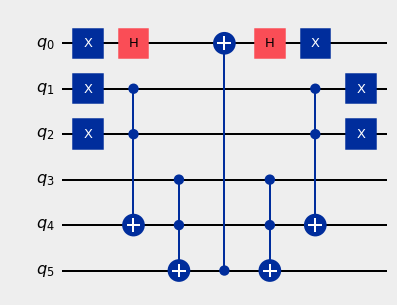

In [5]:
oracle('0001').display()

## Define the diffusion

The diffusion gate operates a symmetry of the state amplitudes around their mean value. It can be decomposed as a wall of Hadamard gate, followed by the Oracle applied on the first qubit, followed by another wall of Hadamard.

In [6]:
def diffusion(nb_qubits: int) -> QCircuit:
    return h_wall(nb_qubits) + oracle('0'*nb_qubits) + h_wall(nb_qubits)

In [7]:
print(diffusion(4))

     ┌───┐┌───┐┌───┐     ┌───┐┌───┐┌───┐┌───┐     
q_0: ┤ H ├┤ X ├┤ H ├─────┤ X ├┤ H ├┤ X ├┤ H ├─────
     ├───┤├───┤└───┘     └─┬─┘└───┘└───┘├───┤┌───┐
q_1: ┤ H ├┤ X ├──■─────────┼─────────■──┤ X ├┤ H ├
     ├───┤├───┤  │         │         │  ├───┤├───┤
q_2: ┤ H ├┤ X ├──■─────────┼─────────■──┤ X ├┤ H ├
     ├───┤├───┤  │         │         │  ├───┤├───┤
q_3: ┤ H ├┤ X ├──┼────■────┼────■────┼──┤ X ├┤ H ├
     └───┘└───┘┌─┴─┐  │    │    │  ┌─┴─┐└───┘└───┘
q_4: ──────────┤ X ├──■────┼────■──┤ X ├──────────
               └───┘┌─┴─┐  │  ┌─┴─┐└───┘          
q_5: ───────────────┤ X ├──■──┤ X ├───────────────
                    └───┘     └───┘               


## Grover's algorithm

In [ ]:
def grover_circuit(marked: str):
    nb_qubits = len(marked)

    circuit = h_wall(nb_qubits)
    
    num_iterations = math.floor(math.pi / (4 * math.asin(math.sqrt(1 / 2**nb_qubits))))

    for _ in range(num_iterations):
        circuit += oracle(marked)
        circuit += diffusion(nb_qubits)

    return circuit

In [ ]:
from mpqp.execution.result import Result
from mpqp.measures import BasisMeasure
from mpqp.execution import run, IBMDevice, Sample

def grover_algorithm(marked: str):
    circuit = grover_circuit(marked)
    nb_qubits = len(marked)
    
    circuit.add(BasisMeasure(list(range(nb_qubits)), shots=10000))

    result = run(circuit, IBMDevice.AER_SIMULATOR)
    assert isinstance(result, Result)
    
    counts = result.counts
    x = counts.index(max(counts))

    return Sample(nb_qubits, index=x).bin_str    
#     return f"{x:b}"

In [14]:
grover_algorithm('111')

[0.0073 0.0078 0.0075 0.0079 0.0081 0.0097 0.0067 0.945 ]


'111'